# Bitcoin Time Series - LSTM


In [34]:
# Necessary library
import pandas as pd
import numpy as np
import os
import math
import datetime as dt
import matplotlib.pyplot as plt

In [37]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [38]:
# Model Building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

In [39]:
# Plotting

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## Loading data

In [40]:
dateparser=lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M')
bitcoin=pd.read_csv("./data/Price/Processed_BTCUSDT/New_BTCUSDT-1h-2022-01.csv", index_col="Open time", date_parser=dateparser)
bitcoin.head(10)

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_16590/2824557367.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
Open time,,,,,,,,,,,
2022-01-01 00:00:00,46210.57,46729.73,46210.55,46650.01,8957.465,01/01/2022 00:59,416444814.3,91267,4777.701,2.221296e+08,0
2022-01-01 01:00:00,46650.00,46944.56,46570.34,46766.78,7276.249,01/01/2022 01:59,340380570.8,73308,3689.837,1.726189e+08,0
2022-01-01 02:00:00,46767.44,46917.87,46709.44,46796.14,4478.713,01/01/2022 02:59,209685983.3,46403,2103.345,9.848722e+07,0
2022-01-01 03:00:00,46796.15,46888.00,46746.32,46789.56,4208.992,01/01/2022 03:59,197079681.7,39070,1928.027,9.028410e+07,0
2022-01-01 04:00:00,46789.55,46868.74,46605.00,46690.81,6149.298,01/01/2022 04:59,287229210.7,63606,2855.818,1.334055e+08,0
2022-01-01 05:00:00,46690.81,47566.66,46657.99,47184.18,14988.008,01/01/2022 05:59,708047313.2,143532,8193.570,3.869317e+08,0
2022-01-01 06:00:00,47184.19,47314.40,46914.84,46972.19,7474.840,01/01/2022 06:59,352269561.1,67979,3343.354,1.576009e+08,0
2022-01-01 07:00:00,46972.19,47247.44,46867.00,47186.83,6227.873,01/01/2022 07:59,292936111.0,61729,3478.601,1.636773e+08,0
2022-01-01 08:00:00,47186.83,47338.00,47060.74,47117.84,6294.515,01/01/2022 08:59,297052698.4,63154,3149.875,1.486699e+08,0


In [41]:
print("Shape",bitcoin.shape)
print("Information", bitcoin.info())

Shape (744, 11)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-01-01 00:00:00 to 2022-01-31 23:00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open                          744 non-null    float64
 1   High                          744 non-null    float64
 2   Low                           744 non-null    float64
 3   Close                         744 non-null    float64
 4   Volume                        744 non-null    float64
 5   Close time                    744 non-null    object 
 6   Quote asset volume            744 non-null    float64
 7   Number of trades              744 non-null    int64  
 8   Taker buy base asset volume   744 non-null    float64
 9   Taker buy quote asset volume  744 non-null    float64
 10  Ignore                        744 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 69.8+ KB
Information 

In [42]:
bitcoin.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
count,744.000000,744.00000,744.000000,744.000000,744.000000,7.440000e+02,744.000000,744.000000,7.440000e+02,744.0
mean,41131.626801,41346.00496,40905.009113,41121.131815,14848.762469,5.956280e+08,144567.075269,7418.610320,2.974023e+08,0.0
std,3646.370941,3612.25080,3677.674967,3642.905183,13078.045574,5.016849e+08,111556.239573,6443.424716,2.461329e+08,0.0
min,33080.000000,33766.81000,32853.830000,33080.000000,3126.437000,1.301846e+08,39070.000000,1647.729000,6.277188e+07,0.0
25%,37714.497500,37888.24750,37547.750000,37714.500000,6659.216000,2.823857e+08,73442.000000,3366.437500,1.421690e+08,0.0
50%,41914.420000,42096.58000,41747.525000,41913.300000,10530.084000,4.311871e+08,106587.000000,5237.078000,2.171178e+08,0.0
75%,43079.140000,43247.81000,42938.797500,43076.970000,17373.805500,6.891593e+08,173889.000000,8867.768750,3.515588e+08,0.0
max,47780.010000,48000.00000,47400.440000,47780.000000,111617.286000,4.253937e+09,984476.000000,55082.365000,2.100417e+09,0.0


## Checking for Null Values

In [43]:
print("The null values:", bitcoin.isnull().values.sum())
print("The NA values:", bitcoin.isnull().values.any())

The null values: 0
The NA values: False


## EDA

In [44]:
# start date time and end date time

start_date=bitcoin.index[0]
end_date=bitcoin.index[-1]

print("Start datetime:", start_date)
print("End datetime:", end_date)

Start datetime: 2022-01-01 00:00:00
End datetime: 2022-01-31 23:00:00


In [45]:
# draw the candlestick chart



In [46]:
# keep the useful columns
columns_keep=['Open','High','Low','Close','Volume']
columns=list(bitcoin.columns.values)
print(columns)
for i in columns_keep:
    columns.remove(i)

bitcoin_new=bitcoin.drop(columns=columns)

['Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']


In [47]:
bitcoin_new

,Open,High,Low,Close,Volume
Open time,,,,,
2022-01-01 00:00:00,46210.57,46729.73,46210.55,46650.01,8957.465
2022-01-01 01:00:00,46650.00,46944.56,46570.34,46766.78,7276.249
2022-01-01 02:00:00,46767.44,46917.87,46709.44,46796.14,4478.713
2022-01-01 03:00:00,46796.15,46888.00,46746.32,46789.56,4208.992
2022-01-01 04:00:00,46789.55,46868.74,46605.00,46690.81,6149.298
...,...,...,...,...,...
2022-01-31 19:00:00,38446.44,38741.73,38358.64,38400.00,16995.608
2022-01-31 20:00:00,38400.01,38552.99,38220.00,38432.32,12091.364
2022-01-31 21:00:00,38432.32,38512.93,38314.42,38395.17,5858.826


In [48]:
names=cycle(['Open','High','Low','Close'])
y_data=[bitcoin_new['Open'],bitcoin_new['High'],bitcoin_new['Low'],bitcoin_new['Close']]
print(type(bitcoin_new.index))
fig=px.line(bitcoin_new,
            x=bitcoin_new.index,
            y=y_data,
            labels={'Date':'Datetime','value':'Bitcoin Price'})
fig.update_layout(title_text='Bitcoin Analysis Chart',
                  font_size=15,
                  font_color='black',
                  legend_title_text='Parameters')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


## Model Building - LSTM

Only consider the close price and datetime for now.

In [49]:
# Parameters

timestep = 24

Epochs = 200

Batch_Size=32

Verbose = 1

split =0.9

In [50]:
# Take the Close Price out
df_close=bitcoin_new[['Close']]
print("Shape of close dataframe:", df_close.shape)

Shape of close dataframe: (744, 1)


#### Split the dataset

In [51]:
# Train: Test = 9:1

train_size=int(len(df_close)*split)
test_size=len(df_close)-train_size

train_data, test_data=df_close[0:train_size], df_close[train_size:len(df_close)]
print("train_data_shape:",train_data.shape)
print("test_data_shape:", test_data.shape)

train_data_shape: (669, 1)
test_data_shape: (75, 1)


#### Normalizing Data

Use the **MinMaxScaler** for the normalizartion

In [52]:
scaler=MinMaxScaler(feature_range=(0,1))
scale_train_data=scaler.fit_transform(train_data)
scale_test_data= scaler.transform(test_data)

#### Create Dataset For Time Series Analysis

Set the timestep

In [53]:
# Use the previous close price as features to predict the next close price

def timestep_matrix(dataset, timestep):
    X_data, y_data=[], []
    for i in range(len(dataset)-timestep-1):
        feature=dataset[i:(i+timestep)]
        X_data.append(feature)
        y_data.append(dataset[i+timestep])
    return np.array(X_data), np.array(y_data)

In [54]:
X_train, y_train = timestep_matrix(scale_train_data, timestep)
X_test, y_test = timestep_matrix(scale_test_data, timestep)

In [55]:
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (644, 24, 1)
y_train Shape: (644, 1)
X_test Shape: (50, 24, 1)
y_test Shape: (50, 1)


#### Model Building


In [56]:
lstm_model=Sequential()

lstm_model.add(LSTM(10,input_shape=(None,1),activation="relu"))

lstm_model.add(Dense(1))

lstm_model.compile(loss= "mean_squared_error", optimizer="adam")


In [57]:
history = lstm_model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=Epochs, batch_size=Batch_Size, verbose=Verbose)

Epoch 1/200
21/21 [==============================] - 1s 8ms/step - loss: 0.1288 - val_loss: 0.0139
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0166 - val_loss: 0.0015
Epoch 3/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 7.5726e-04
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 6.2021e-04
Epoch 5/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 6.8253e-04
Epoch 6/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 6.4548e-04
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.6154e-04
Epoch 8/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 6.0334e-04
Epoch 9/200
21/21 [==============================] - 0s 3ms/step - loss: 9.1907e-04 - val_loss: 5.3928e-04
Epoch 10/200
21/21 [==============================] - 0s 3ms/step - loss: 8.9

#### Plot Loss vs Validation Loss

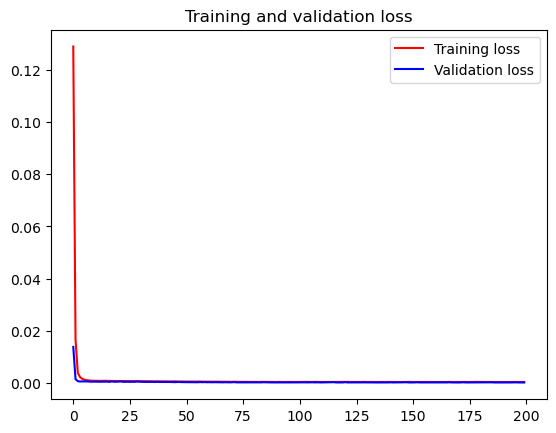

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt

loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [59]:
### prediction and check performance.metrics

train_predict=lstm_model.predict(X_train)
test_predict=lstm_model.predict(X_test)

print("Train prediction shape:", train_predict.shape)
print("Test prediction shape:", test_predict.shape)

2/2 [==============================] - 0s 1ms/step
Train prediction shape: (644, 1)
Test prediction shape: (50, 1)


#### Model Evaluation

In [60]:
# Transform back to original form
train_pred=scaler.inverse_transform(train_predict)
test_pred=scaler.inverse_transform(test_predict)

train_true=scaler.inverse_transform(y_train.reshape(-1,1))
test_true=scaler.inverse_transform(y_test.reshape(-1,1))

In [61]:
# Evaluation metrics
# RMSE MSE MAE

# Evaluation metrices RMSE and MAE
print("Train data MSE: ", mean_squared_error(train_true,train_pred))
print("Train data MAE: ", mean_absolute_error(train_true,train_pred))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_true,test_pred)))
print("Test data MSE: ", mean_squared_error(test_true,test_pred))
print("Test data MAE: ", mean_absolute_error(test_true,test_pred))
print("Test data MAPE: ", np.mean(np.abs(test_true-test_pred)/np.abs(test_true)))

Train data MSE:  88980.44736068507
Train data MAE:  210.26921316964277
-------------------------------------------------------------------------------------
Test data RMSE:  233.9299811080361
Test data MSE:  54723.236061206124
Test data MAE:  151.6927062499999
Test data MAPE:  0.004030537423401076


In [62]:
# Variance Regression Score
print("Train data explained variance regression score:",
      explained_variance_score(train_true, train_pred))
print("Test data explained variance regression score:",
      explained_variance_score(test_true, test_pred))

Train data explained variance regression score: 0.9929250016940835
Test data explained variance regression score: 0.7798734282539355


In [63]:
# R Square Score for Regression
print("Train data R2 score:", r2_score(train_true, train_pred))
print("Test data R2 score:", r2_score(test_true, test_pred))

Train data R2 score: 0.992924966641955
Test data R2 score: 0.7787038885238785


In [29]:
# Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(train_true, train_pred))
print("Test data MGD: ", mean_gamma_deviance(test_true, test_pred))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(train_true, train_pred))
print("Test data MPD: ", mean_poisson_deviance(test_true, test_pred))

Train data MGD:  8.12791407800874e-05
Test data MGD:  5.719330945996859e-05
----------------------------------------------------------------------
Train data MPD:  3.1766212406218304
Test data MPD:  2.1515636899168022


In [30]:
# comparison of the true close price and predicted close price

look_back=timestep
trainPredictPlot=np.empty_like(df_close)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_pred)+look_back,:]=train_pred
print("Train predicted data:", trainPredictPlot.shape)

Train predicted data: (744, 1)


In [31]:
# Shift test predictions for plotting

testPredictPlot=np.empty_like(df_close)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df_close)-1,:] = test_pred
print("Test predicted data: ", testPredictPlot.shape)

Test predicted data:  (744, 1)


In [32]:
names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': df_close.index,
                       'original_close': df_close['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,
              x=plotdf['date'],
              y=[plotdf['original_close'],plotdf['train_predicted_close'],                       plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Open time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

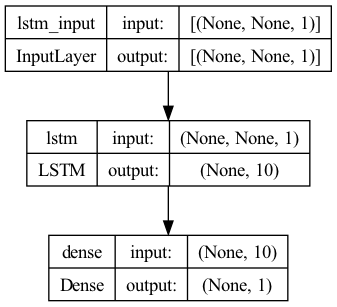

In [33]:
# Model Structure
from keras.utils.vis_utils import plot_model
from IPython.display import Image
version=1
file_path_name = "./model_image/"+"LSTM_Prediction_"+str(version)+".png"
plot_model(lstm_model, to_file=file_path_name, show_shapes=True, show_layer_names=True)

Image(filename=file_path_name)